tgb - 2/8/2019 - This script aims at predicting convective heating, longwave cooling and shortwave heating separately. It follows the notebook 002 that predicts:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  
***
to now predict:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 
***  
Two remarks:  
1) The energy conservation constraint will now involve a mass-weighted integral of QRL and QRS, knowing that:  
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRL\left(p\right)=FLNS-FLNT
$$
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRS\left(p\right)=FSNT-FSNS
$$  
2) For consistency, we shoud calculate FLNS, FSNS as residuals from (QRL,FLNT) and (QRS,FSNS) respectively

## 1) Preprocess all the necessary variables
### 1.1) Build feature, target and initial normalization files

In [1]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.models import *
from cbrain.utils import limit_mem
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
PREFIX = '32_col_rad_12m_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


tgb - 2/8/2019 - We need to modify the pp_config file to incorporate the 3D radiative heating profiles, as well as the layers of the network to conserve mass, energy, and infer the surface radiative balance.  
The new pp file will be called "32col_rad_tbeucler_local.yml", while the prefix will be "32_col_rad_12m_"


In [2]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_rad_tbeucler_local.yml \
--aqua_names '*.h1.0000-*-0[1-12]-*' \
--out_pref 32_col_rad_12m_train

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 2.72 s
Number of time steps: 1152
Cut time steps: [  95  191  287  383  479  575  671  767  863  959 1055]
Cut time steps: [  95  191  287  383  479  575  671  767  863  959 1055]
Time checkpoint create datasets: 2.98 s
Time checkpoint reshape and rechunk: 11.81 s
Compute means and stds
Saving normalization file: /local/Tom.Beucler/SPCAM_PHYS/32_col_rad_12m_train_norm.nc
Time checkpoint normalization arrays: 276.57 s
Time checkpoint rechunk and ds: 278.11 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_rad_12m_train_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_rad_12m_train_targets.nc
Total time: 395.09 s


### 1.2) Create validation dataset


In [3]:
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_rad_tbeucler_local.yml \
--aqua_names '*.h1.0001-*-0[1-3]-*' \
--out_pref 32_col_rad_12m_valid --ext_norm Nope

GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 0.96 s
Number of time steps: 432
Cut time steps: [143 287]
Cut time steps: [143 287]
Time checkpoint create datasets: 1.15 s
Time checkpoint reshape and rechunk: 4.41 s
Load external normalization file
Time checkpoint normalization arrays: 4.41 s
Time checkpoint rechunk and ds: 4.75 s
Save features: /local/Tom.Beucler/SPCAM_PHYS/32_col_rad_12m_valid_features.nc
Save targets: /local/Tom.Beucler/SPCAM_PHYS/32_col_rad_12m_valid_targets.nc
Total time: 54.80 s


### 1.3) Shuffle the training dataset
tgb - 1/16/2019 - Adapted from Stephan's entire worlflow for 32 column run
tgb - 2/8/2019 - Make sure to reserve enough RAM for the shuffling, especially for shuffling the training dataset

In [4]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_rad_12m_train

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_train_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_train_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_train_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_train_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 1/1 [00:45<00:00, 45.49s/it]


In [5]:
!python cbrain/shuffle_ds.py --pref $TRAINDIR/32_col_rad_12m_valid

Reading files: /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_valid_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_valid_targets.nc
Creating files: /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_valid_shuffle_features.nc /local/Tom.Beucler/SPCAM_PHYS//32_col_rad_12m_valid_shuffle_targets.nc
GitPython not found. Please install for better reproducibility.
GitPython not found. Please install for better reproducibility.
100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.26s/it]


### 1.4) Change the output's normalization using pressure levels

tgb - 2/6/2019 - See notebook 001 for careful test of each of the steps below  
tgb - 2/8/2019 - Now y=[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN], so we have to multiply the first 6 * 30 elements by dP and the next 30 elements by dP / dt.

In [6]:
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')  

# Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  
  
dt = 30*60; # timestep
ds.target_conv[:210] = np.multiply(ds.target_conv[:210],np.concatenate((dP,dP,dP,dP,dP,dP,np.divide(dP,dt))))
print(ds.target_conv)
  
# Copy old normalization file
path1 = os.path.join(TRAINDIR,PREFIX+'train_norm.nc')
path2 = os.path.join(TRAINDIR,PREFIX+'train_oldnorm.nc')
!cp $path1 $path2  
  
# Create new dataset with characteristics of modified ds
new_ds = xr.Dataset({
            'feature_means': ds.feature_means,
            'feature_stds': ds.feature_stds,
            'feature_mins': ds.feature_mins,
            'feature_maxs': ds.feature_maxs,
            'target_means': ds.target_means,
            'target_stds': ds.target_stds,
            'target_mins': ds.target_mins,
            'target_maxs': ds.target_maxs,
            'feature_names': ds.feature_names,
            'target_names': ds.target_names,
            'feature_stds_by_var': ds.feature_stds_by_var,
            'target_conv': ds.target_conv
        })  
  
# 4.3 Write new data set to initial target_conv file
!rm $path1 # Remove normalization file  
new_ds.to_netcdf(path1) # Save the new dataset as the new normalization file

# 4.4 Close the xarray handler
xr.open_dataset(path1).close() # Don't forget to close xarray handler!!

<xarray.DataArray 'target_conv' (target_lev: 218)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, ..., 2.501000e+06,
       2.501000e+09, 2.501000e+06], dtype=float32)
Coordinates:
  * target_lev  (target_lev) int64 0 1 2 3 4 5 6 ... 211 212 213 214 215 216 217


## 2) Create data generator and produce data sample


### 2.1) Create data generator from training dataset

In [7]:
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'train_shuffle_features.nc',
    target_fn=PREFIX+'train_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 9338880 samples in 18240 batches
Features have shape 304; targets have shape 218


In [8]:
gen = train_gen_obj.return_generator()
# Produce data sample
x, y = next(gen)
# and check its shape
x.shape, y.shape

((512, 304), (512, 218))

### 2.2) Create data generator from validation dataset and produce sample

In [9]:
valid_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'valid_shuffle_features.nc',
    target_fn=PREFIX+'valid_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 3514368 samples in 6864 batches
Features have shape 304; targets have shape 218


In [10]:
validgen = valid_gen_obj.return_generator()

xval, yval = next(validgen)

xval.shape, yval.shape

((512, 304), (512, 218))

## 3) Building the custom layers for mass/energy conserving neural networks

## 3.1) Load all the normalization variables

In [11]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (218,)
hyai.shape= (31,)
hybi.shape= (31,)


## 3.2) Check radiative integrals in numpy
tgb - 2/8/2019 - We are checking that:
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRL\left(p\right)=FLNS-FLNT
$$
$$
\int_{0}^{p_{s}}\frac{dp}{g}c_{p}QRS\left(p\right)=FSNT-FSNS
$$  
Using the normalization to units W/m2, we are checking that:  
$$
\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta QRL=FLNS-FLNT
$$
$$
\int_{0}^{\widetilde{p_{s}}}d\widetilde{p}\cdot\delta QRS=FSNT-FSNS
$$
x = [QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  
y = [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]  
In this sub-section we have several objectives:  
1) Making sure that for y, the integral relation holds  
2) Coding the surface radiation layer in numpy  
3) Convert the surface radiation layer to tensorflow

### 3.2.1) Checking consistency of radiative-integrals

(array([  2.,   1.,   4.,  13., 373.,  59.,  40.,  14.,   5.,   1.]),
 array([-7.98387497e-05, -6.30554577e-05, -4.62721658e-05, -2.94888739e-05,
        -1.27055819e-05,  4.07771000e-06,  2.08610019e-05,  3.76442939e-05,
         5.44275858e-05,  7.12108778e-05,  8.79941697e-05]),
 <a list of 10 Patch objects>)

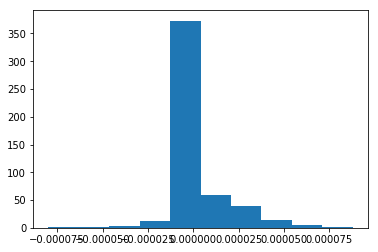

In [21]:
x,y = next(gen) # x.shape = 304 & y.shape = 218
import copy
inp = copy.copy(x)

# 0) Constants
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
G = 9.80616; # Reference gravity constant [m.s-2]
P0 = 1e5; # Reference surface pressure [Pa]
        
# 1) Get non-dimensional pressure differences (p_tilde above)
PS = np.add( np.multiply( inp[:,300], fdiv[300]), fsub[300])
# Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
            np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                     np.multiply(normq[:30], \
                           G), L_V)
# dp_tilde = dp/dp_norm
# Wondering about broadcasting here...
# tf.div or simply \ would support broadcasting 
dP_TILD = np.divide( dP, dP_NORM)

# 2) Radiative integrals
SWVEC = np.multiply( dP_TILD, y[:, 150:180])
SWINT = np.sum( SWVEC, axis=1)
SWNET = y[:,210]-y[:,211] # FSNT-FSNS

LWVEC = np.multiply( dP_TILD, y[:, 120:150])
LWINT = np.sum( LWVEC, axis=1) # LW integral
LWNET = y[:,213]-y[:,212] # FLNS-FLNT

plt.hist(SWINT-SWNET)

### 3.2.2) Coding surface radiation layer in numpy
tgb - 2/8/2019 - I plan on using the surface radiation layer before the mass and enthalpy conservation layers in the conserving network architecture (C), so let's work backwards from y to find what the input/output would be:  
y = [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]  
y_before_ent = [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND \ {TPHYSTND30}, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]  
y_before_mass = [PHQ \ {PHQ30}, PHCLDLIQ, PHCLDICE, TPHYSTND \ {TPHYSTND30}, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]  
y_before_surfrad = [PHQ \ {PHQ30}, PHCLDLIQ, PHCLDICE, TPHYSTND \ {TPHYSTND30}, QRL, QRS, DTVKE, FSNT, FLNT, PRECT, PRECTEND, PRECST, PRECSTEN]  
We would like to code the surface radiation layer so that:  
(Surface radiation layer): y_before_surfrad [214] |---> y_before_mass [216]

y before surf rad (512, 214)
Target y after surf rad (512, 216)
y after surf rad (512, 216)


(array([ 10.,  14.,  31.,  77., 112., 115.,  89.,  47.,  13.,   4.]),
 array([-3.08260020e-05, -2.61837707e-05, -2.15415394e-05, -1.68993080e-05,
        -1.22570767e-05, -7.61484537e-06, -2.97261404e-06,  1.66961730e-06,
         6.31184863e-06,  1.09540800e-05,  1.55963113e-05]),
 <a list of 10 Patch objects>)

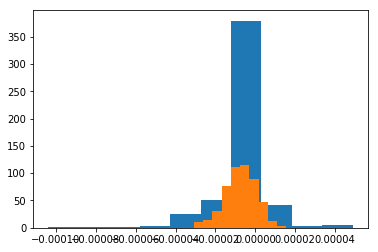

In [53]:
x,y = next(gen) # x.shape = 304 & y.shape = 218
import copy
inp = copy.copy(x)
# Mimic the vector that comes in
ybef = np.concatenate([y[:,:29],y[:,30:119],y[:,120:211],y[:,212:213],y[:,214:]],1)
ytar = np.concatenate([y[:,:29],y[:,30:119],y[:,120:]],1)
print('y before surf rad',ybef.shape)
print('Target y after surf rad',ytar.shape)

# 0) Constants
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
G = 9.80616; # Reference gravity constant [m.s-2]
L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
P0 = 1e5; # Reference surface pressure [Pa]
        
# 1) Get non-dimensional pressure differences (p_tilde above)
PS = np.add( np.multiply( inp[:,300], fdiv[300]), fsub[300])
# Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
P = np.add( np.multiply( P0, hyai), \
            np.multiply( PS[:,None], hybi))
dP = np.subtract( P[:, 1:], P[:, :-1])
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                     np.multiply(normq[:30], \
                           G), L_V)
# dp_tilde = dp/dp_norm
# Wondering about broadcasting here...
# tf.div or simply \ would support broadcasting 
dP_TILD = np.divide( dP, dP_NORM)

# 2) Radiative integrals
SWVEC = np.multiply( dP_TILD, ybef[:, 148:178])
SWINT = np.sum( SWVEC, axis=1)
#SWNET = y[:,210]-y[:,211] # FSNT-FSNS

LWVEC = np.multiply( dP_TILD, ybef[:, 118:148])
LWINT = np.sum( LWVEC, axis=1) # LW integral
#LWNET = y[:,213]-y[:,212] # FLNS-FLNT

# 3) Infer surface radiative fluxes from radiative integrals and TOA radiative fluxes
FSNS = np.subtract(ybef[:,208], SWINT) # FSNS = FSNT-SWINT
FLNS = np.add(ybef[:,209], LWINT) # FLNS = FLNT+LWINT

# 4) Concatenate the input of the dense layer with 
# the net surface radiative fluxes to form 
# the output of the surface radiation layer
yaft = np.concatenate([ybef[:, :209], np.expand_dims(FSNS, axis=1),\
                       ybef[:, 209:210], np.expand_dims(FLNS, axis=1),\
                      ybef[:, 210:]], 1)
print('y after surf rad', yaft.shape)

plt.hist(yaft[:,209]-ytar[:,209])
plt.hist(yaft[:,211]-ytar[:,211])

### 3.2.3) Port the surface radiation layer to tensorflow

In [55]:
class SurRadLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
    
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'output_dim': self.output_dim}
        base_config = super(SurRadLay, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
    
        # Split between the inputs inp & the output of the densely connected
        # neural network, massout
        inp, densout = arrs
        
        # 0) Constants
        C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]

        # 1) Get non-dimensional pressure differences (p_tilde above)
        PS = tfm.add( tfm.multiply( inp[:,300], self.fdiv[300]), self.fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                          G),\
                             L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)

        # 2) Radiative integrals
        SWVEC = tfm.multiply( dP_TILD, densout[:, 148:178])
        SWINT = tfm.reduce_sum( SWVEC, axis=1)

        LWVEC = tfm.multiply( dP_TILD, densout[:, 118:148])
        LWINT = tfm.reduce_sum( LWVEC, axis=1) # LW integral

        # 3) Infer surface radiative fluxes from radiative integrals and TOA radiative fluxes
        FSNS = tfm.subtract( densout[:,208], SWINT) # FSNS = FSNT-SWINT
        FLNS = tfm.add( densout[:,209], LWINT) # FLNS = FLNT+LWINT

        # 4) Concatenate the input of the dense layer with 
        # the net surface radiative fluxes to form 
        # the output of the surface radiation layer
        out = tf.concat([densout[:, :209], tf.expand_dims(FSNS, axis=1),\
                               densout[:, 209:210], tf.expand_dims(FLNS, axis=1),\
                              densout[:, 210:]], 1)
        
        return out
    
    def compute_output_shape(self, input_shape):
        # tgb - 2/7/2019 - Wrap the returned output shape in Tensorshape
        # to avoid problems with custom layers & eager execution
        # https://github.com/tensorflow/tensorflow/issues/20805
        return tf.TensorShape((input_shape[0][0], self.output_dim)) 
    # The layer takes inputs from the previous layer that have shape 124
    # and outputs y of shape 126 to be fed to the mass cons. layers

## 3.3) Adapt mass conservation layer to new output format
tgb - 2/8/2019 - For now, change indices of MasConsLay in cbrain/models

In [56]:
class MasConsLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
    
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'output_dim': self.output_dim}
        base_config = super(MasConsLay, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):        
        # Split between the inputs inp & the output of the densely connected
        # neural network, sradout
        inp, sradout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,300], self.fdiv[300]), self.fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                   G), L_V)
        # dp_tilde = dp/dp_norm
        # Wondering about broadcasting here...
        # tf.div or simply \ would support broadcasting 
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # 2) Calculate cloud water vertical integral from level 1 to level 30
        # The indices are tricky here because we are missing del(q_v)@(level 30)
        # so e.g. q_liq@(level 1) is the 30th element of the output of the 
        # previous dense layer
        CLDVEC = tfm.multiply( dP_TILD, \
                                  tfm.add( sradout[:, 29:59], sradout[:, 59:89]))
        CLDINT = tfm.reduce_sum( CLDVEC, axis=1)
        
        # 3) Calculate water vapor vertical integral from level 1 to level 29
        VAPVEC = tfm.multiply( dP_TILD[:, :29], \
                                  sradout[:, :29])
        VAPINT = tfm.reduce_sum( VAPVEC, axis=1)
        
        # 4) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( inp[:,303], self.fdiv[303]), self.fsub[303])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        # tgb - 2/8/2019 - This is the only line modified from the large-scale version 002
        PREC = tfm.add( sradout[:, 212], sradout[:, 213])
        
        # 5) Infer water vapor tendency at level 30 as a residual
        # Composing tfm.add 3 times because not sure how to use tfm.add_n
        DELQV30 = tfm.divide( \
                             tfm.add( tfm.add( tfm.add (\
                                                        LHF, tfm.negative(PREC)), \
                                              tfm.negative(CLDINT)), \
                                     tfm.negative(VAPINT)), \
                             dP_TILD[:, 29])
        
        # 6) Concatenate the water tendencies with the newly inferred tendency
        # to get the final vector out of shape (#samples,125) with
        # [DELQ, DELCLDLIQ, DELCLDICE, 
        # TPHYSTND\{TPHYSTND AT SURFACE}, FSNT, FSNS, FLNT, FLNS, PRECT PRECTEND]
        # Uses https://www.tensorflow.org/api_docs/python/tf/concat
        DELQV30 = tf.expand_dims(DELQV30,1) # Adds dimension=1 to axis=1
        out = tf.concat([sradout[:, :29], DELQV30, sradout[:, 29:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        # tgb - 2/7/2019 - Wrap the returned output shape in Tensorshape
        # to avoid problems with custom layers & eager execution
        # https://github.com/tensorflow/tensorflow/issues/20805
        return tf.TensorShape((input_shape[0][0], self.output_dim)) 
    # The output has size 125=30*4+6-1
    # and is ready to be fed to the energy conservation layer
    # before we reach the total number of outputs = 126

## 3.4) Adapt mass conservation layer to new output format
tgb - 2/8/2019 - For now, change indices of EntConsLay in cbrain/models

In [58]:
class EntConsLay(Layer):
    
    def __init__(self, fsub, fdiv, normq, hyai, hybi, output_dim, **kwargs):
        self.fsub = fsub # Subtraction for normalization of inputs 
        self.fdiv = fdiv # Division for normalization of inputs
        self.normq = normq # Normalization of output's water concentration
        self.hyai = hyai # CAM constants to calculate d_pressure
        self.hybi = hybi # CAM constants to calculate d_pressure
        self.output_dim = output_dim # Dimension of output
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)  # Be sure to call this somewhere!
        
    # tgb - 2/6/2019 - following https://github.com/keras-team/keras/issues/4871
    def get_config(self):
        config = {'fsub': list(self.fsub), 'fdiv': list(self.fdiv),
                  'normq': list(self.normq), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'output_dim': self.output_dim}
        base_config = super(EntConsLay, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):
        
        # Split between the inputs inp & the output of the densely connected
        # neural network, massout
        inp, massout = arrs
        
        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]
        
        # 1) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( inp[:,300], self.fdiv[300]), self.fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, self.hyai), \
                    tfm.multiply( PS[:,None], self.hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
                             tfm.multiply(self.normq[:30], \
                                          G),\
                             L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)
        
        # 2) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                                      tfm.add( massout[:,215], massout[:,216]),\
                                                      tfm.add( massout[:,213], massout[:,214])),\
                                        L_F),\
                          L_V)
        
        # 3) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 3.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( massout[:,209], massout[:,210]),\
                      tfm.subtract( massout[:,212], massout[:,211]))
        # 3.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( inp[:,302], self.fdiv[302]), self.fsub[302])
        # 3.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, massout[:, 119:149])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)
        
        # 4) Calculate tendency of normalized column water vapor due to phase change
        # 4.1) Unnormalize latent heat flux
        LHF = tfm.add( tfm.multiply( inp[:,303], self.fdiv[303]), self.fsub[303])
        # 4.2) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, massout[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 4.3) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                         PHQINT, LHF),\
                                           L_S),\
                             L_V)
        
        # 5) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                            tfm.reduce_sum(\
                                                           tfm.multiply( dP_TILD, massout[:, 30:60]),\
                                                           axis=1),\
                                            L_F),\
                              L_V)
        
        # 6) Same operation for temperature but only integrate from level 1 to level 29
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :29], massout[:, 90:119]), axis=1)

        # 7) Now calculate dT30 as a residual
        dT30 = tfm.divide(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(\
                                                                          PHAS,RAD),\
                                                                  SHF),\
                                                          KEDINT),\
                                                  tfm.negative( SPDQINT)),\
                                          tfm.negative( SPDQCINT)),\
                                  tfm.negative( DTINT)),\
                          dP_TILD[:, 29])
        dT30 = tf.expand_dims(dT30,1)

        out = tf.concat([massout[:, :119], dT30, massout[:, 119:]], 1)
        return out
    
    def compute_output_shape(self, input_shape):
        # tgb - 2/7/2019 - Wrap the returned output shape in Tensorshape
        # to avoid problems with custom layers & eager execution
        # https://github.com/tensorflow/tensorflow/issues/20805
        return tf.TensorShape((input_shape[0][0], self.output_dim))
    # and is ready to be used in the cost function

## 3.5) Keep custom loss function
$$
\mathrm{Loss}\left[\mathrm{W^{2}.m^{-4}}\right]=\alpha\cdot\mathrm{MSE}+\left(1-\alpha\right)\left(\mathrm{Enthalpy\ residual}^{2}+\mathrm{Mass\ residual}^{2}\right)\ \ |\ \ \alpha\in[0,1]
$$
tgb - 2/5/2019- Inspired from 
1) https://stackoverflow.com/questions/46858016/keras-custom-loss-function-to-pass-arguments-other-than-y-true-and-y-pred for the custom loss function  
2) https://stackoverflow.com/questions/46464549/keras-custom-loss-function-accessing-current-input-pattern for using the inputs in the custom loss function
Uses the function  massent_check as reference for the square Energy and mass residuals

In [59]:
def customLoss(input_tensor,fsub,fdiv,normq,hyai,hybi,alpha = 0.5):

        # tgb - 2/5/2019 - Loss function written above
    def lossFunction(y_true,y_pred):    
        loss = tfm.multiply(alpha, mse(y_true, y_pred))
        loss += tfm.multiply(tfm.subtract(1.0,alpha), \
                            massent_res(input_tensor,y_pred,fsub,fdiv,normq,hyai,hybi))
        return loss

    # tgb - 2/5/2019 - Mass and enthalpy residual function
    # Adapted from massent_check by converting numpy to tensorflow
    def massent_res(x,y,fsub,fdiv,normq,hyai,hybi):

        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]   

        # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( x[:,300], fdiv[300]), fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, hyai), \
        tfm.multiply( PS[:,None], hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
        tfm.multiply(normq[:30], \
                  G),\
        L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)

        # WATER.1) Calculate water vertical integral from level 1 to level 30
        WATVEC = tfm.multiply( dP_TILD, tfm.add(tfm.add(y[:, :30],\
                                                        y[:, 30:60]),\
                                                y[:, 60:90]))
        WATINT = tfm.reduce_sum( WATVEC, axis=1)

        # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( x[:,303], fdiv[303]), fsub[303])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tfm.add( y[:, 154], y[:, 155])

        # WATER.FINAL) Residual = E-P-DWATER/DT
        WATRES = tfm.add(tfm.add(LHF,\
                                 tfm.negative(PREC)),\
                         tfm.negative(WATINT))

        # ENTHALPY.1) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                              tfm.add( y[:,156], y[:,157]),\
                                              tfm.add( y[:,154], y[:,155])),\
                                      L_F),\
                         L_V)

        # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( y[:,150], y[:,151]),\
                      tfm.subtract( y[:,153], y[:,152]))
        # 2.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( x[:,302], fdiv[302]), fsub[302])
        # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, y[:, 120:150])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)

        # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
        # 3.1) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, y[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 3.2) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                     PHQINT, LHF),\
                                        L_S),\
                           L_V)

        # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                      tfm.reduce_sum(\
                                             tfm.multiply( dP_TILD, y[:, 30:60]),\
                                             axis=1),\
                                      L_F),\
                         L_V)

        # ENTHALPY.5) Same operation for temperature tendency
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)

        # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
        ENTRES = tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(SPDQINT,\
                                                                 SPDQCINT),\
                                                         DTINT),\
                                                 tfm.negative(RAD)),\
                                         tfm.negative(SHF)),\
                                 tfm.negative(PHAS)),\
                         tfm.negative(KEDINT))
        # Return sum of water and enthalpy square residuals
        return tfm.add( tfm.square(WATRES), tfm.square(ENTRES))

    return lossFunction

# 4) Build neural networks

## 4.1) Formulate different models

### 4.1.1) Mass/energy conserving model (C)

In [63]:
# Conserving model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(214, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
sradout = SurRadLay(
    input_shape=(214,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 216
)([inp, densout])
massout = MasConsLay(
    input_shape=(216,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 217
)([inp, sradout])
out = EntConsLay(
    input_shape=(157,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 158
)([inp, massout])
C_rad_5dens = Model(inputs=inp, outputs=out)

### 4.1.2) Unconstrained model (U)

In [64]:
# Unconstrained model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
U_rad_5dens = Model(inputs=inp, outputs=out)

### 4.1.3) Weakly-constrained models (W)

In [65]:
# Weakly-constrained models with 5 dense layers
# alpha=0.01
inp001 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp001)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W001_rad_5dens = Model(inputs=inp001, outputs=out)
# alpha=0.5
inp05 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp05)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W05_rad_5dens = Model(inputs=inp05, outputs=out)
# alpha=0.99
inp099 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp099)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W099_rad_5dens = Model(inputs=inp099, outputs=out)

## 4.2) Compile the models

### 4.2.1) Use mean square error as loss function

In [66]:
C_rad_5dens.compile('rmsprop','mse')

In [67]:
U_rad_5dens.compile('rmsprop','mse')

### 4.2.2) Use custom loss function

In [68]:
W001_rad_5dens.compile(loss=customLoss(inp001,fsub,fdiv,normq,hyai,hybi,alpha = 0.01),\
                       optimizer='rmsprop')

In [69]:
W05_rad_5dens.compile(loss=customLoss(inp05,fsub,fdiv,normq,hyai,hybi,alpha = 0.5),\
                       optimizer='rmsprop')

In [70]:
W099_rad_5dens.compile(loss=customLoss(inp099,fsub,fdiv,normq,hyai,hybi,alpha = 0.99),\
                       optimizer='rmsprop')

### 4.2.3) Check model summaries

In [73]:
W001_rad_5dens.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 304)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               156160    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 512)               0         
__________

## 4.3) Train the models

In [ ]:
hC_rad_5dens = C_rad_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hlru_lagr001_5dens = lru_lagr001_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hlru_lagr05_5dens = lru_lagr05_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hlru_lagr099_5dens = lru_lagr099_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

In [32]:
#hist_cons_5dens = mod_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
#                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hlru_uncons_5dens = lru_uncons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hlru_lagr001_5dens = lru_lagr001_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hlru_lagr05_5dens = lru_lagr05_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hlru_lagr099_5dens = lru_lagr099_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
18240/18240 [==============================] - 87s 5ms/step - loss: 154.2219 - val_loss: 132.6228
Epoch 2/20
18240/18240 [==============================] - 86s 5ms/step - loss: 128.9841 - val_loss: 123.7811
Epoch 3/20
18240/18240 [==============================] - 86s 5ms/step - loss: 124.9521 - val_loss: 121.8379
Epoch 4/20
18240/18240 [==============================] - 86s 5ms/step - loss: 122.8963 - val_loss: 121.3261
Epoch 5/20
18240/18240 [==============================] - 86s 5ms/step - loss: 121.5276 - val_loss: 117.6229
Epoch 6/20
18240/18240 [==============================] - 86s 5ms/step - loss: 120.5954 - val_loss: 121.6579
Epoch 7/20
18240/18240 [==============================] - 86s 5ms/step - loss: 119.8641 - val_loss: 119.1938
Epoch 8/20
18240/18240 [==============================] - 86s 5ms/step - loss: 119.1895 - val_loss: 118.0816
Epoch 9/20
18240/18240 [==============================] - 86s 5ms/step - loss: 118.6060 - val_loss: 118.1369
Epoch 10/20
18240/1

In [138]:
helu_cons_5dens = elu_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
18240/18240 [==============================] - 121s 7ms/step - loss: 336.0688 - val_loss: 296.3247
Epoch 2/20
18240/18240 [==============================] - 120s 7ms/step - loss: 323.7683 - val_loss: 4825.6380
Epoch 3/20
18240/18240 [==============================] - 120s 7ms/step - loss: 3513402.9420 - val_loss: 249521.3613
Epoch 4/20
18240/18240 [==============================] - 120s 7ms/step - loss: 9099521.8309 - val_loss: 1026.3550
Epoch 5/20
18240/18240 [==============================] - 120s 7ms/step - loss: 4348890.6503 - val_loss: 66898.1627
Epoch 6/20
18240/18240 [==============================] - 120s 7ms/step - loss: 12398213.6755 - val_loss: 776569.5652
Epoch 7/20
18240/18240 [==============================] - 120s 7ms/step - loss: 1885788.1738 - val_loss: 28543841.1049
Epoch 8/20
18240/18240 [==============================] - 120s 7ms/step - loss: 9232902.0532 - val_loss: 453502.1447
Epoch 9/20
18240/18240 [==============================] - 120s 7ms/step - los

In [17]:
#hadad_cons_5dens = adad_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
#                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
#hadam_cons_5dens = adam_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
#                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
18240/18240 [==============================] - 118s 6ms/step - loss: 143.5000 - val_loss: 124.6938
Epoch 2/20
18240/18240 [==============================] - 118s 6ms/step - loss: 125.1558 - val_loss: 120.1842
Epoch 3/20
18240/18240 [==============================] - 118s 6ms/step - loss: 121.0790 - val_loss: 119.0333
Epoch 4/20
18240/18240 [==============================] - 117s 6ms/step - loss: 118.6843 - val_loss: 117.5636
Epoch 5/20
18240/18240 [==============================] - 118s 6ms/step - loss: 117.2775 - val_loss: 117.4019
Epoch 6/20
18240/18240 [==============================] - 118s 6ms/step - loss: 120.1646 - val_loss: 116.4241
Epoch 7/20
18240/18240 [==============================] - 117s 6ms/step - loss: 119.7096 - val_loss: 115.8942
Epoch 8/20
18240/18240 [==============================] - 117s 6ms/step - loss: 130.5041 - val_loss: 116.9329
Epoch 9/20
18240/18240 [==============================] - 117s 6ms/step - loss: 117.4099 - val_loss: 115.7471
Epoch 10/2

In [20]:
hrmsp_cons_5dens = rmsp_cons_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=20, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/20
18240/18240 [==============================] - 112s 6ms/step - loss: 170.8195 - val_loss: 129.4829
Epoch 2/20
18240/18240 [==============================] - 111s 6ms/step - loss: 135.4032 - val_loss: 123.5065
Epoch 3/20
18240/18240 [==============================] - 111s 6ms/step - loss: 130.3239 - val_loss: 120.4736
Epoch 4/20
18240/18240 [==============================] - 112s 6ms/step - loss: 127.6721 - val_loss: 117.6087
Epoch 5/20
18240/18240 [==============================] - 111s 6ms/step - loss: 126.0467 - val_loss: 119.3136
Epoch 6/20
18240/18240 [==============================] - 111s 6ms/step - loss: 124.7047 - val_loss: 116.3503
Epoch 7/20
18240/18240 [==============================] - 111s 6ms/step - loss: 123.7101 - val_loss: 119.1667
Epoch 8/20
18240/18240 [==============================] - 111s 6ms/step - loss: 122.9899 - val_loss: 116.2005
Epoch 9/20
18240/18240 [==============================] - 111s 6ms/step - loss: 122.4724 - val_loss: 121.2840
Epoch 10/2

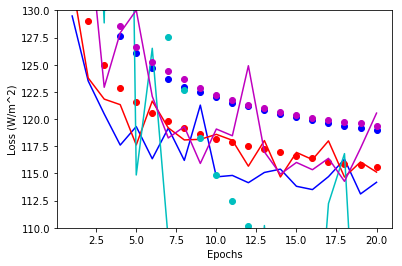

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

for index in range (5):
    if index==0: hdict = hrmsp_cons_5dens.history; colo = 'bo'; col = 'b'; lab = 'C';
    elif index==1: hdict = hlru_uncons_5dens.history; colo = 'ro'; col = 'r'; lab = 'U';
    elif index==2: hdict = hlru_lagr001_5dens.history; colo = 'go'; col = 'g'; lab = 'W001';
    elif index==3: hdict = hlru_lagr05_5dens.history; colo = 'co'; col = 'c'; lab = 'W05';
    elif index==4: hdict = hlru_lagr099_5dens.history; colo = 'mo'; col = 'm'; lab = 'W099';
        
    
    train_loss_values = hdict['loss']
    valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

#plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (W/m^2)')
plt.ylim((110, 130))
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# for legend at the right place
#ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#          ncol=5, fancybox=True, shadow=True); 
plt.show()

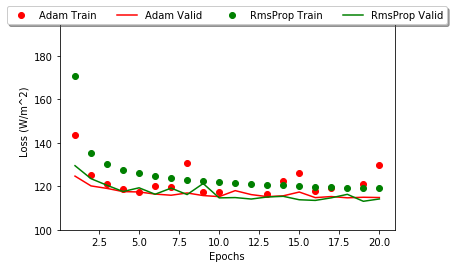

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(); ax = plt.subplot(111)

for index in range (2):
    if index==2: hdict = hist_cons_5dens.history; colo = 'bo'; col = 'b'; lab = 'Adadelta';
    elif index==0: hdict = hadam_cons_5dens.history; colo = 'ro'; col = 'r'; lab = 'Adam';
    elif index==1: hdict = hrmsp_cons_5dens.history; colo = 'go'; col = 'g'; lab = 'RmsProp';
        
    
    train_loss_values = hdict['loss']; valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

plt.xlabel('Epochs'); plt.ylabel('Loss (W/m^2)'); plt.ylim((100, 200))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True); plt.show()

In [ ]:
# import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)

for index in range (2):
    if index==0: hdict = hist_cons_5dens.history; colo = 'bo'; col = 'b'; lab = 'ReLU';
    elif index==2: hdict = helu_cons_5dens.history; colo = 'ro'; col = 'r'; lab = 'ExpLU';
    elif index==1: hdict = hlru_cons_5dens.history; colo = 'go'; col = 'g'; lab = 'LeakyReLU';
        
    
    train_loss_values = hdict['loss']; valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

plt.xlabel('Epochs', fontsize=25); plt.ylabel('Loss (W per m2)', fontsize=25);
plt.xticks(fontsize=25); plt.yticks(fontsize=25)
plt.ylim((0, 500))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize=25); plt.show()

truth= [ 7.9672202e-05  4.7920624e-04  2.4025740e-02  5.5195879e-02
  1.1413122e-01  9.9763870e-02  2.2796452e-02  8.7691424e-03
  9.2103053e-03  7.1256983e-01  7.7988184e+02  5.6302869e+02
  2.6318073e+02  6.2778019e+01  6.9902046e-03 -7.8684932e-01
  0.0000000e+00 -2.4350360e-01]
unconstrained= [  0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.3625866 788.68677   562.22266
 282.95648    55.21782     5.0673413   0.          0.          0.       ]
conserving= [0.         0.4019227  0.00784189 0.03601322 0.         0.46972626
 0.20347854 0.31218743 0.21515115 0.         0.         0.
 0.         0.         0.15628235 0.2403318  0.10572945 0.        ]


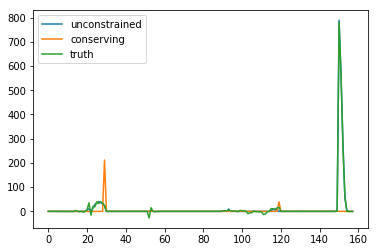

In [34]:
pred_uncons = mod_uncons_5dens.predict_on_batch(x)
pred_cons = mod_cons_5dens.predict_on_batch(x)
ind_test = 150;
plt.plot(pred_uncons[ind_test,:], label='unconstrained')
plt.plot(pred_cons[ind_test,:], label='conserving')
plt.plot(y[ind_test,:], label='truth')
plt.legend();
print('truth=',y[ind_test,140:])
print('unconstrained=',pred_uncons[ind_test,140:])
print('conserving=',pred_cons[ind_test,140:])

#### Step 5: Check energy and mass conservation for the predictions
If we coded the mass/enthalpy conservation layers properly  
pred_cons from the mass/enthalpy-conserving model_cons should conserve mass/energy  
pred_uncons which is a "naive" dense network should not a priori conserve mass/energy  
The function below is directly adapted from the tested mass/enthalpy conservation layers in numpy that have been used to develop the tensorflow layers

In [47]:
def massent_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="graph"):
    import numpy as np
    # 0) Constants
    G = 9.80616; # Reference gravity constant [m.s-2]
    L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
    L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
    L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
    P0 = 1e5; # Reference surface pressure [Pa]   

    # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
    # In the input vector, PS is the 151st element after 
    # the first elements = [QBP, ..., VBP with shape 30*5=150]
    PS = np.add( np.multiply( x[:,300], fdiv[300]), fsub[300])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
    np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
    np.multiply(normq[:30], \
              G),\
    L_V)
    # dp_tilde = dp/dp_norm
    dP_TILD = np.divide( dP, dP_NORM)

    # WATER.1) Calculate water vertical integral from level 1 to level 30
    WATVEC = np.multiply( dP_TILD, y[:, :30] + y[:, 30:60] + y[:, 60:90])
    WATINT = np.sum( WATVEC, axis=1)

    # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
    # E-P is already normalized to units W.m-2 in the output vector
    # so all we need to do is input-unnormalize LHF that is taken from the input vector
    LHF = np.add( np.multiply( x[:,303], fdiv[303]), fsub[303])
    # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
    # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
    PREC = np.add( y[:, 154], y[:, 155])

    # WATER.FINAL) Residual = E-P-DWATER/DT
    WATRES = LHF-PREC-WATINT
    
    # ENTHALPY.1) Calculate net energy input from phase change and precipitation
    # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
    PHAS = np.divide( np.multiply( np.subtract(\
                                          np.add( y[:,156], y[:,157]),\
                                          np.add( y[:,154], y[:,155])),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
    # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
    RAD = np.add(\
            np.subtract( y[:,150], y[:,151]),\
            np.subtract( y[:,153], y[:,152]))
    # 2.2) Unnormalize sensible heat flux
    SHF = np.add( np.multiply( x[:,302], fdiv[302]), fsub[302])
    # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
    # turbulent kinetic energy energy dissipative heating
    KEDVEC = np.multiply( dP_TILD, y[:, 120:150])
    KEDINT = np.sum( KEDVEC, axis=1)
    
    # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
    # 3.1) Column water vapor is the column integral of specific humidity
    PHQVEC = np.multiply( dP_TILD, y[:, :30])
    PHQINT = np.sum( PHQVEC, axis=1)
    # 3.2) Multiply by L_S/L_V to normalize (explanation above)
    SPDQINT = np.divide( np.multiply( np.subtract(\
                                                 PHQINT, LHF),\
                                    L_S),\
                       L_V)
    
    # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
    SPDQCINT = np.divide( np.multiply(\
                                  np.sum(\
                                         np.multiply( dP_TILD, y[:, 30:60]),\
                                         axis=1),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.5) Same operation for temperature tendency
    DTINT = np.sum( np.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)
    
    # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
    ENTRES = SPDQINT+SPDQCINT+DTINT-RAD-SHF-PHAS-KEDINT
    
    if outtype=="graph":
    
        import matplotlib.pyplot as plt
        from matplotlib import rc
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')

        plt.subplot(121)
        plt.hist(WATRES)
        plt.xlabel(r"$\mathrm{Water\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)

        plt.subplot(122)
        plt.hist(ENTRES)
        plt.xlabel(r"$\mathrm{Enthalpy\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    elif outtype=="list":
    
        return WATRES,ENTRES 

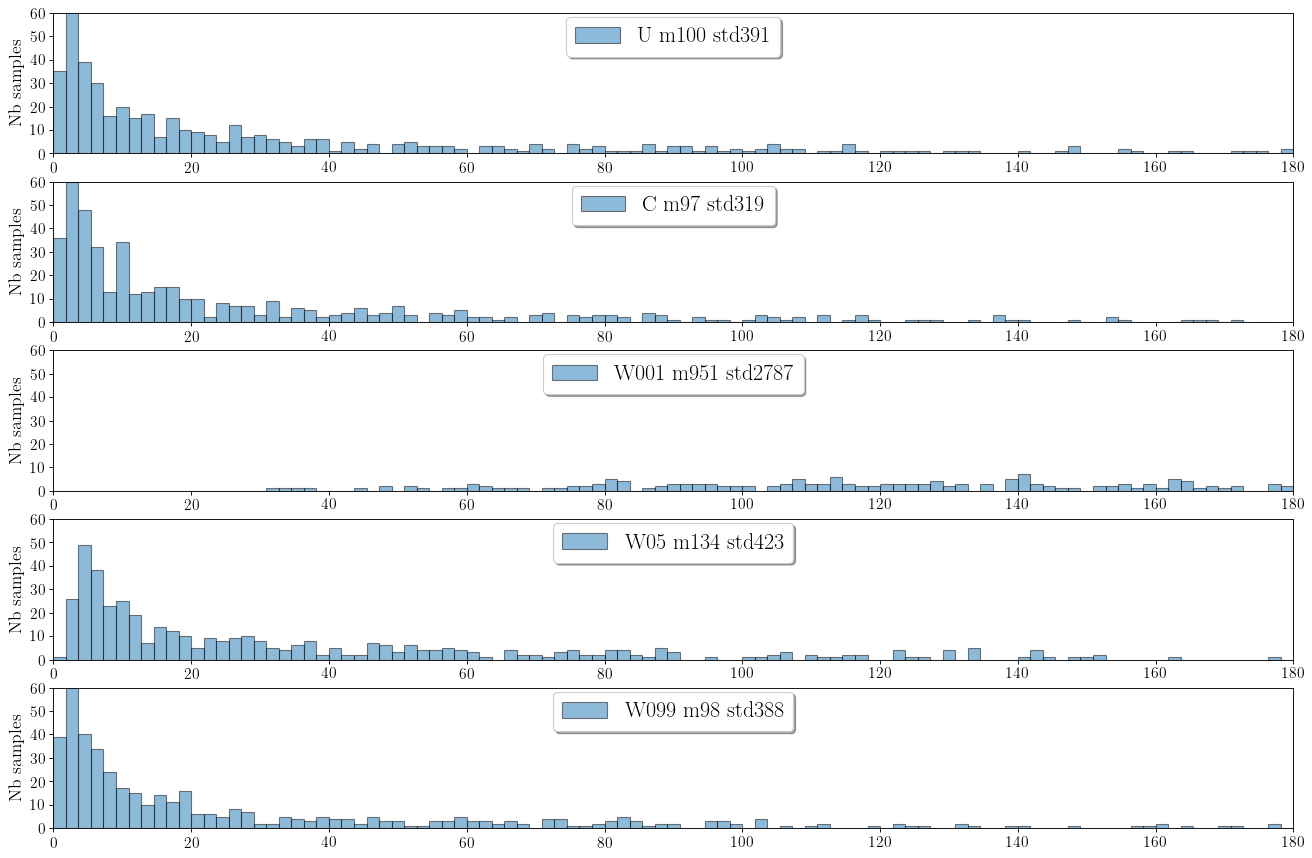

In [67]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 180; bins = np.linspace(0, XMAX, 100)

xval, yval = next(validgen)

for index in range (5):
    if index==0: pred = lru_uncons_5dens.predict_on_batch(xval); lab = 'U';
    elif index==1: pred = lru_cons_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = lru_lagr001_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = lru_lagr05_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = lru_lagr099_5dens.predict_on_batch(xval); lab = 'W099';

    res = np.mean((pred-yval)**2, axis=1);
    
    ax = plt.subplot(5,1,index+1)
    ax.hist(res, bins, alpha=0.5, edgecolor='k', label = lab+' m%i' %np.mean(res)+' std%i' %np.std(res))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 60)); plt.xlim((0, XMAX));
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

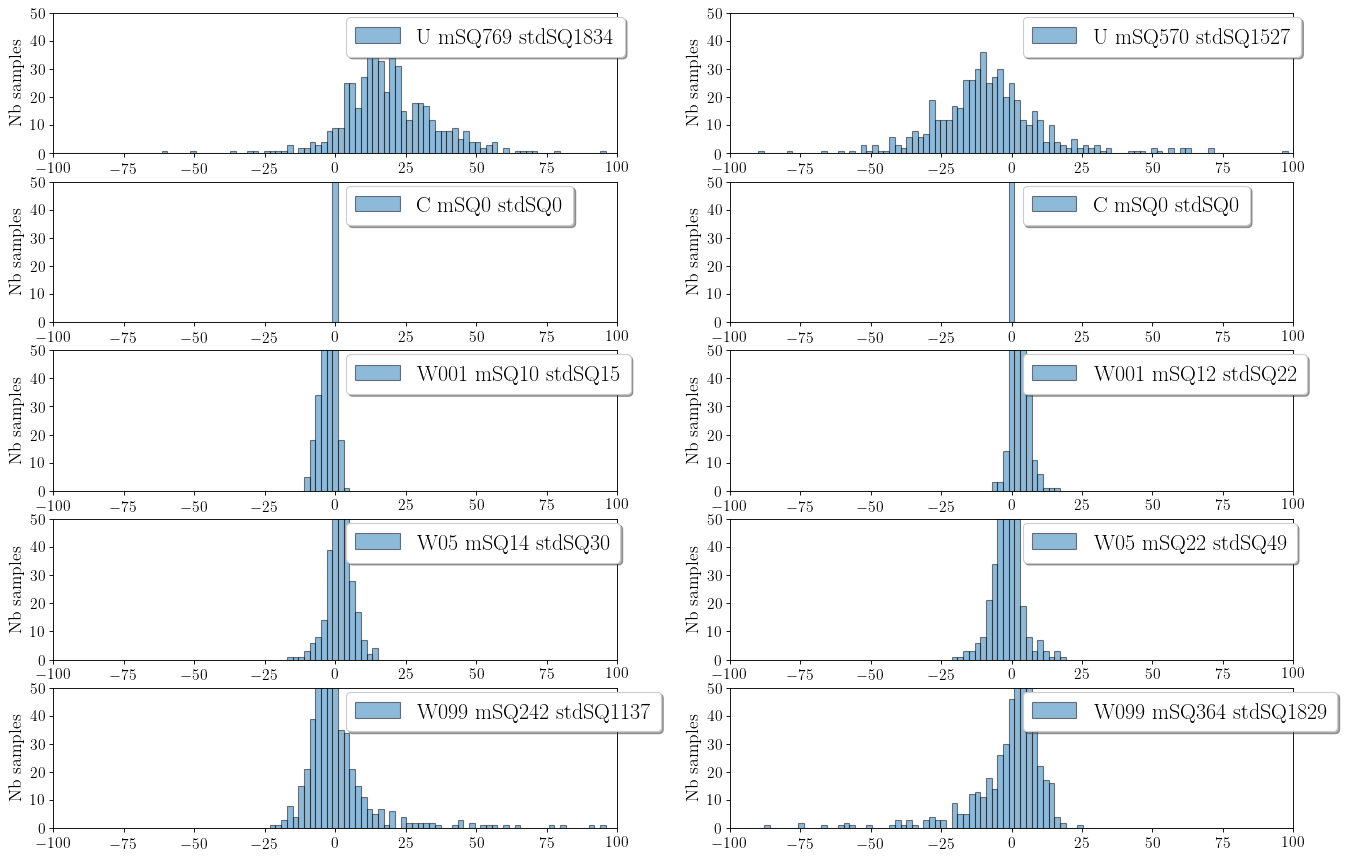

In [68]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 100; bins = np.linspace(-XMAX, XMAX, 100)

xval, yval = next(validgen)

for index in range (5):
    if index==0: pred = lru_uncons_5dens.predict_on_batch(xval); lab = 'U';
    elif index==1: pred = lru_cons_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = lru_lagr001_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = lru_lagr05_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = lru_lagr099_5dens.predict_on_batch(xval); lab = 'W099';

    watres,entres = massent_check(xval,pred,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="list");

    ax = plt.subplot(5,2,2*index+1)
    ax.hist(watres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(watres**2)+' stdSQ%i' %np.std(watres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20);
    
    ax = plt.subplot(5,2,2*index+2)
    ax.hist(entres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(entres**2)+' stdSQ%i' %np.std(entres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

#### Step 6: Check positivity of water species
There are two necessary steps:  
1) Load the water species concentrations "before physics" from the input vector and unnormalize them  
2) Invert the output normalization to get the water concentrations "after physics"

$$
\delta q_{v,i,l}\left(p\right)=\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}\ \Rightarrow\ q_{v,i,l}^{a}\left(p\right)=q_{v,i,l}^{b}\left(p\right)+\frac{g\Delta t}{L_{v}\Delta p_{\mathrm{norm}}}\delta q_{v,i,l}\left(p\right)
$$

In [145]:
def watpos_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,dt=30*60):
    
    import numpy as np

    # 1) Extract water species concentrations from inputs
    QVB = np.add( np.multiply( x[:, :30], fdiv[ :30]), fsub[ :30])
    QLB = np.add( np.multiply( x[:, 30:60], fdiv[ 30:60]), fsub[ 30:60])
    QSB = np.add( np.multiply( x[:, 60:90], fdiv[ 60:90]), fsub[ 60:90])

    # 2) Inverse output normalization and get water concentration after physics
    QVA = QVB + np.divide( dt*y[:, :30] , normq[:30])
    QLA = QLB + np.divide( dt*y[:, 30:60] , normq[:30])
    QSA = QSB + np.divide( dt*y[:, 60:90] , normq[:30])

    import matplotlib.pyplot as plt
    from matplotlib import rc
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(231)
    plt.hist(1e3*QVA)
    plt.xlabel(r"$\mathrm{Water\ vapor\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(232)
    plt.hist(1e3*QLA)
    plt.xlabel(r"$\mathrm{Liquid\ water\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(233)
    plt.hist(1e3*QSA)
    plt.xlabel(r"$\mathrm{Ice\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplot(234)
    plt.hist(1e3*(QVA-QVB))
    plt.xlabel(r"$\mathrm{Water\ vapor\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(235)
    plt.hist(1e3*(QLA-QLB))
    plt.xlabel(r"$\mathrm{Liquid\ water\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(236)
    plt.hist(1e3*(QSA-QSB))
    plt.xlabel(r"$\mathrm{Ice\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

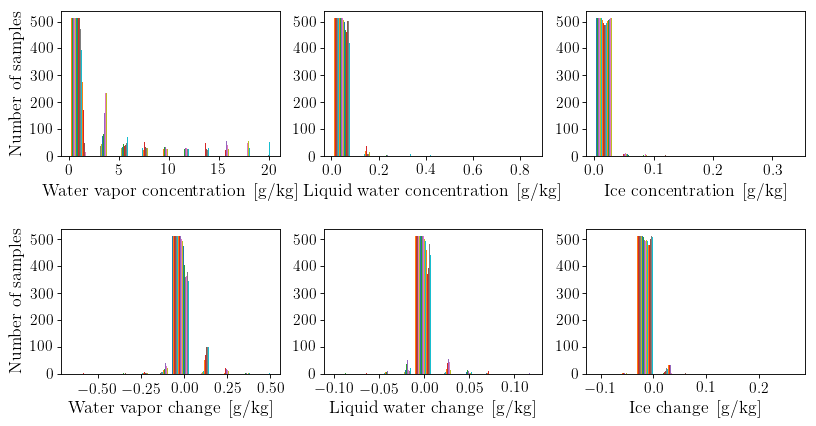

In [146]:
watpos_check(xval,yval,fsub,fdiv,normq,dt)

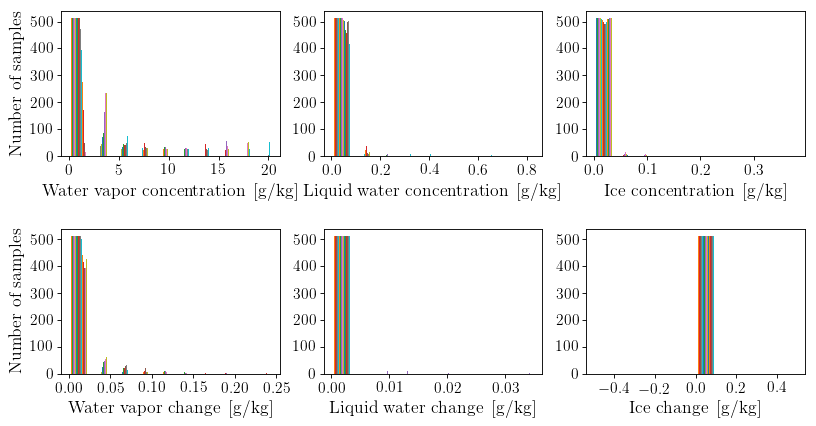

In [154]:
watpos_check(xval,pred6,fsub,fdiv,normq,dt)

#### Last step: Save trained models as h5 files

In [74]:
%cd $TRAINDIR/HDF5_DATA
!pwd
#lru_lagr05_5dens.save('lru_lagr05_5dens.h5')
#lru_lagr001_5dens.save('lru_lagr001_5dens.h5')
#lru_lagr099_5dens.save('lru_lagr099_5dens.h5')
#lru_uncons_5dens.save('lru_uncons_5dens.h5')
#lru_cons_5dens.save('lru_cons_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


In [55]:
rmsp_cons_5dens.save_weights('tmp.h5')

In [66]:
lru_cons_5dens.load_weights('tmp.h5')